# Apache Spark: Initial Analysis

## Introduction

This is the first in a series of Jupyter notebooks dedicated to learning various aspects of Apache Spark. Since Spark is a tool used for data processing and analysis, a data set is required for this lesson. The data source used is the Taxi Trips data set from San Francisco. The data set was downloaded as a CSV file. I converted the CSV file to a Parquet file.

For my Spark instance, I am running Spark and this notebook in a Docker container.

## A Short Note on Spark Clusters

An Apache Spark application has three function: a driver program (the one that created the Spark Context), a cluster manager, and one or more cluster workers. I am running this on my laptop, so all of these functions are running on my machine. For additional information on Spark clusters, please refer to the [documentation](https://spark.apache.org/docs/latest/cluster-overview.html).

## Setup

The below cell creates a Spark session, names the app, and sets the configuration.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import matplotlib.pyplot as plt
%matplotlib inline

spark = (
    SparkSession
        .builder
        .appName('test')
        .config("spark.driver.memory", "4g")
        .getOrCreate()
)

# The following sets up the ability to output a nicely formatted table.
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)


## Load the Data

The following cell reads a Parquet file into a Spark DataFrame.

In [2]:
df = spark.read.parquet('/home/jovyan/work/Taxi_Trips_SF_20250621.parquet')

## Print the Schema

Let's show the schema of the DataFrame. The schema will show each of the columns in the DataFrame along with the data type.

In [3]:
df.printSchema()

root
 |-- vehicle_placard_number: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- start_time_local: string (nullable = true)
 |-- end_time_local: string (nullable = true)
 |-- pickup_location_latitude: string (nullable = true)
 |-- pickup_location_longitude: string (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location_latitude: string (nullable = true)
 |-- dropoff_location_longitude: string (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- hail_type: string (nullable = true)
 |-- paratransit: string (nullable = true)
 |-- sfo_pickup: string (nullable = true)
 |-- qa_flags: string (nullable = true)
 |-- fare_type: string (nullable = true)
 |-- meter_fare_amount: string (nullable = true)
 |-- upfront_pricing: string (nullable = true)
 |-- promo_rate: string (nullable = true)
 |-- tolls: string (nullable = true)
 |-- sf_exit_fee: string (nullable = true)
 |-- other_fees: string (nullable = true)
 |-- tip: string

## Examine the Data

The first step in my analysis is to examine the data. The below will output 10 rows from the DataFrame.

In [4]:
df.limit(10)

vehicle_placard_number,driver_id,start_time_local,end_time_local,pickup_location_latitude,pickup_location_longitude,pickup_location,dropoff_location_latitude,dropoff_location_longitude,dropoff_location,hail_type,paratransit,sfo_pickup,qa_flags,fare_type,meter_fare_amount,upfront_pricing,promo_rate,tolls,sf_exit_fee,other_fees,tip,extra_amount,total_fare_amount,fare_time_milliseconds,trip_distance_meters,data_as_of,data_loaded_at
1509,B-0039,2023/01/07 08:55:...,2023/01/07 09:18:...,37.615,-122.39,POINT (-122.39 37...,37.784,-122.404,POINT (-122.404 3...,street,0,1,NULL,meter_fare,51.6,NULL,NULL,NULL,NULL,0,0,5.5,57.1,925000,21882.4,2025/04/04 10:36:...,2025/04/07 04:16:...
0656,D-0988,2022/12/07 01:21:...,2022/12/07 01:31:...,37.786,-122.395,POINT (-122.395 3...,37.781,-122.411,POINT (-122.411 3...,dispatch,0,0,NULL,meter_fare,11.3,NULL,NULL,NULL,NULL,0,0,0,11.3,192000,2188.24,2025/04/04 10:37:...,2025/04/07 04:16:...
1309,D-4356,2023/10/05 08:45:...,2023/10/05 09:03:...,37.8,-122.439,POINT (-122.439 3...,37.759,-122.436,POINT (-122.436 3...,dispatch,0,0,LP-DR-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0,0,0,17.15,484000,4682.19,2025/04/04 10:37:...,2025/04/07 04:16:...
1202,D-1433,2023/01/07 08:56:...,2023/01/07 09:19:...,37.615,-122.39,POINT (-122.39 37...,37.795,-122.404,POINT (-122.404 3...,street,0,1,IT-,meter_fare,52.25,NULL,NULL,NULL,5.5,NULL,0,NULL,57.75,1394852,22530.8,2025/04/04 10:36:...,2025/04/07 04:16:...
1212,D-3902,2022/12/07 01:21:...,2022/12/07 01:34:...,37.814,-122.251,POINT (-122.251 3...,37.864,-122.268,POINT (-122.268 3...,street,0,0,IT-,meter_fare,22.35,NULL,NULL,NULL,NULL,NULL,0,NULL,22.35,825041,7885.8,2025/04/04 10:37:...,2025/04/07 04:16:...
1309,D-4356,2023/10/05 08:45:...,2023/10/05 09:03:...,37.8,-122.439,POINT (-122.439 3...,37.759,-122.436,POINT (-122.436 3...,dispatch,0,0,LP-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0,0,0,17.15,484000,4682.19,2025/04/04 10:37:...,2025/04/07 04:16:...
0434,A-9674,2022/12/07 01:21:...,2022/12/07 01:40:...,37.617,-122.384,POINT (-122.384 3...,37.774,-122.425,POINT (-122.425 3...,street,0,1,IT-,meter_fare,43.15,NULL,NULL,NULL,5.5,NULL,0,NULL,48.65,1169878,18990.3,2025/04/04 10:37:...,2025/04/07 04:16:...
0480,B-2006,2023/01/07 08:56:...,2023/01/07 09:02:...,37.776,-122.421,POINT (-122.421 3...,37.788,-122.432,POINT (-122.432 3...,dispatch,0,0,IT-,meter_fare,9.35,NULL,NULL,NULL,NULL,NULL,0,NULL,9.35,338325,2092.1,2025/04/04 10:36:...,2025/04/07 04:16:...
0362,D-6944,2023/10/05 08:46:...,2023/10/05 08:52:...,37.788,-122.408,POINT (-122.408 3...,37.791,-122.414,POINT (-122.414 3...,street,0,0,LP-DR-IT-,meter_fare,7.4,NULL,NULL,NULL,NULL,0,0,0,7.4,89000,901.04,2025/04/04 10:37:...,2025/04/07 04:16:...
0030,N-1089,2023/01/07 08:56:...,2023/01/07 09:05:...,37.787,-122.408,POINT (-122.408 3...,37.78,-122.413,POINT (-122.413 3...,street,0,0,NULL,meter_fare,8.7,NULL,NULL,NULL,NULL,NULL,0,NULL,8.7,540746,965.6,2025/04/04 10:36:...,2025/04/07 04:16:...


## Data Cleanup

As seen in the above schema, all of the columns have the data type of string. I am going to convert the datetime and numerics to more appropriate data types to ease the later analysis. 


In [5]:

df = df.withColumn("start_time_local", F.to_timestamp("start_time_local", 'y/M/d h:m:s a'))
df = df.withColumn("end_time_local", F.to_timestamp("end_time_local", 'y/M/d h:m:s a'))
df = df.withColumn("pickup_location_latitude", df.pickup_location_latitude.cast(T.DoubleType()))
df = df.withColumn("pickup_location_longitude", df.pickup_location_longitude.cast(T.DoubleType()))
df = df.withColumn("dropoff_location_latitude", df.pickup_location_latitude.cast(T.DoubleType()))
df = df.withColumn("dropoff_location_longitude", df.pickup_location_longitude.cast(T.DoubleType()))
df = df.withColumn("paratransit", df.paratransit.cast(T.IntegerType()))
df = df.withColumn("sfo_pickup", df.sfo_pickup.cast(T.IntegerType()))
df = df.withColumn("meter_fare_amount", df.meter_fare_amount.cast(T.DoubleType()))
df = df.withColumn("upfront_pricing", df.upfront_pricing.cast(T.DoubleType()))
df = df.withColumn("promo_rate", df.promo_rate.cast(T.DoubleType()))
df = df.withColumn("tolls", df.tolls.cast(T.DoubleType()))
df = df.withColumn("sf_exit_fee", df.sf_exit_fee.cast(T.DoubleType()))
df = df.withColumn("other_fees", df.other_fees.cast(T.DoubleType()))
df = df.withColumn("tip", df.tip.cast(T.DoubleType()))
df = df.withColumn("extra_amount", df.extra_amount.cast(T.DoubleType()))
df = df.withColumn("total_fare_amount", df.total_fare_amount.cast(T.DoubleType()))
df = df.withColumn("fare_time_milliseconds", df.fare_time_milliseconds.cast(T.IntegerType()))
df = df.withColumn("trip_distance_meters", df.trip_distance_meters.cast(T.DoubleType()))
df = df.withColumn("data_as_of", F.to_timestamp("data_as_of", 'y/M/d h:m:s a'))
df = df.withColumn("data_loaded_at", F.to_timestamp("data_loaded_at", 'y/M/d h:m:s a'))


In [6]:
df.printSchema()

root
 |-- vehicle_placard_number: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- start_time_local: timestamp (nullable = true)
 |-- end_time_local: timestamp (nullable = true)
 |-- pickup_location_latitude: double (nullable = true)
 |-- pickup_location_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location_latitude: double (nullable = true)
 |-- dropoff_location_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- hail_type: string (nullable = true)
 |-- paratransit: integer (nullable = true)
 |-- sfo_pickup: integer (nullable = true)
 |-- qa_flags: string (nullable = true)
 |-- fare_type: string (nullable = true)
 |-- meter_fare_amount: double (nullable = true)
 |-- upfront_pricing: double (nullable = true)
 |-- promo_rate: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- sf_exit_fee: double (nullable = true)
 |-- other_fees: double (nullable = true)
 |-- tip

In [7]:
df.limit(10)

vehicle_placard_number,driver_id,start_time_local,end_time_local,pickup_location_latitude,pickup_location_longitude,pickup_location,dropoff_location_latitude,dropoff_location_longitude,dropoff_location,hail_type,paratransit,sfo_pickup,qa_flags,fare_type,meter_fare_amount,upfront_pricing,promo_rate,tolls,sf_exit_fee,other_fees,tip,extra_amount,total_fare_amount,fare_time_milliseconds,trip_distance_meters,data_as_of,data_loaded_at
1509,B-0039,2023-01-07 20:55:45,2023-01-07 21:18:11,37.615,-122.39,POINT (-122.39 37...,37.615,-122.39,POINT (-122.404 3...,street,0,1,NULL,meter_fare,51.6,NULL,NULL,NULL,NULL,0.0,0.0,5.5,57.1,925000,21882.4,2025-04-04 10:36:57,2025-04-07 16:16:16
0656,D-0988,2022-12-07 13:21:04,2022-12-07 13:31:13,37.786,-122.395,POINT (-122.395 3...,37.786,-122.395,POINT (-122.411 3...,dispatch,0,0,NULL,meter_fare,11.3,NULL,NULL,NULL,NULL,0.0,0.0,0.0,11.3,192000,2188.24,2025-04-04 10:37:03,2025-04-07 16:16:16
1309,D-4356,2023-10-05 20:45:50,2023-10-05 21:03:53,37.8,-122.439,POINT (-122.439 3...,37.8,-122.439,POINT (-122.436 3...,dispatch,0,0,LP-DR-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0.0,0.0,0.0,17.15,484000,4682.19,2025-04-04 10:37:06,2025-04-07 16:16:16
1202,D-1433,2023-01-07 20:56:05,2023-01-07 21:19:20,37.615,-122.39,POINT (-122.39 37...,37.615,-122.39,POINT (-122.404 3...,street,0,1,IT-,meter_fare,52.25,NULL,NULL,NULL,5.5,NULL,0.0,NULL,57.75,1394852,22530.8,2025-04-04 10:36:57,2025-04-07 16:16:16
1212,D-3902,2022-12-07 13:21:05,2022-12-07 13:34:50,37.814,-122.251,POINT (-122.251 3...,37.814,-122.251,POINT (-122.268 3...,street,0,0,IT-,meter_fare,22.35,NULL,NULL,NULL,NULL,NULL,0.0,NULL,22.35,825041,7885.8,2025-04-04 10:37:03,2025-04-07 16:16:16
1309,D-4356,2023-10-05 20:45:50,2023-10-05 21:03:53,37.8,-122.439,POINT (-122.439 3...,37.8,-122.439,POINT (-122.436 3...,dispatch,0,0,LP-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0.0,0.0,0.0,17.15,484000,4682.19,2025-04-04 10:37:06,2025-04-07 16:16:16
0434,A-9674,2022-12-07 13:21:06,2022-12-07 13:40:35,37.617,-122.384,POINT (-122.384 3...,37.617,-122.384,POINT (-122.425 3...,street,0,1,IT-,meter_fare,43.15,NULL,NULL,NULL,5.5,NULL,0.0,NULL,48.65,1169878,18990.3,2025-04-04 10:37:03,2025-04-07 16:16:16
0480,B-2006,2023-01-07 20:56:25,2023-01-07 21:02:04,37.776,-122.421,POINT (-122.421 3...,37.776,-122.421,POINT (-122.432 3...,dispatch,0,0,IT-,meter_fare,9.35,NULL,NULL,NULL,NULL,NULL,0.0,NULL,9.35,338325,2092.1,2025-04-04 10:36:57,2025-04-07 16:16:16
0362,D-6944,2023-10-05 20:46:24,2023-10-05 20:52:36,37.788,-122.408,POINT (-122.408 3...,37.788,-122.408,POINT (-122.414 3...,street,0,0,LP-DR-IT-,meter_fare,7.4,NULL,NULL,NULL,NULL,0.0,0.0,0.0,7.4,89000,901.04,2025-04-04 10:37:06,2025-04-07 16:16:16
0030,N-1089,2023-01-07 20:56:48,2023-01-07 21:05:49,37.787,-122.408,POINT (-122.408 3...,37.787,-122.408,POINT (-122.413 3...,street,0,0,NULL,meter_fare,8.7,NULL,NULL,NULL,NULL,NULL,0.0,NULL,8.7,540746,965.6,2025-04-04 10:36:57,2025-04-07 16:16:16


## Write the Cleaned Data to A New Parquet File

Let's write the cleaned data to a new Parquet file that can be used in further Notebooks so this cleaning step does not need to be done in each one.

#### <span style="color:red;">Note:</span>

This has been written out so it can be used in other notebooks. Commenting this out since it is not needed.

In [8]:

# df.write.mode("overwrite").parquet("file:///home/jovyan/work/Taxi_Trips_SF_20250621_clean.parquet")


## Read the Cleaned Data

Now let's read the cleaned data into a new DataFrame and print out the schema.

In [27]:
# df_clean = spark.read.parquet('/home/jovyan/work/Taxi_Trips_SF_20250621_clean.parquet')

# df_clean.printSchema()

root
 |-- vehicle_placard_number: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- start_time_local: timestamp (nullable = true)
 |-- end_time_local: timestamp (nullable = true)
 |-- pickup_location_latitude: double (nullable = true)
 |-- pickup_location_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location_latitude: double (nullable = true)
 |-- dropoff_location_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- hail_type: string (nullable = true)
 |-- paratransit: integer (nullable = true)
 |-- sfo_pickup: integer (nullable = true)
 |-- qa_flags: string (nullable = true)
 |-- fare_type: string (nullable = true)
 |-- meter_fare_amount: double (nullable = true)
 |-- upfront_pricing: double (nullable = true)
 |-- promo_rate: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- sf_exit_fee: double (nullable = true)
 |-- other_fees: double (nullable = true)
 |-- tip

## Count the Number of Records in the DataFrame

The count() method will print out the number of records in the DataFrame.

In [10]:
df.count()

4129083

## The describe() Method.

The describe() method prints some summary statistics about each column in the DataFrame.

#### <span style="color:red;">Note:</span>
The describe method takes a long time to execute. Comment it out to avoid this or leave it uncommented to see the output.

In [11]:
#df.describe()

## Count the Number of Trips by Driver

The following cell will count the number of trips taken by each driver.

In [12]:

df2 = df.groupBy("driver_id").agg(F.count("driver_id").alias("cnt")).orderBy(F.col("cnt").desc())


## Plot the Data

You can use Pandas and matplotlib to create a chart from the DataFrame. The DataFrame needs to be converted to a Pandas DataFrame and then it can be charted using matplotlib. In order to keep the chart reasonable, the plotted data is limited to the top 20 drivers by trip count.

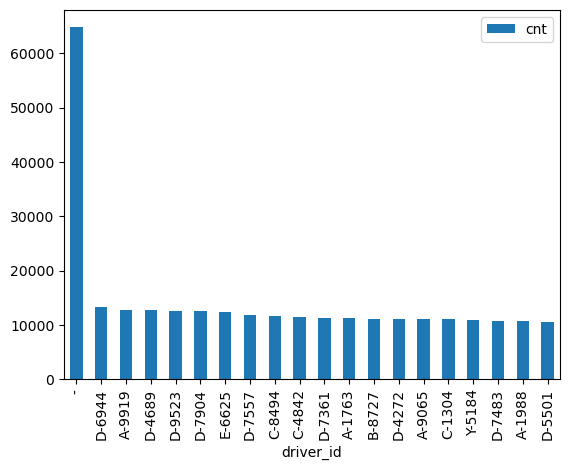

In [13]:
df3 = df2.limit(20).toPandas()
df3.plot(kind="bar", x="driver_id", y="cnt")
plt.show()

## Calculate the Average Number of Trips per Driver

The following cell will calculate the average number of trips per driver using the Spark avg function.

In [14]:
df2.select(F.avg("cnt")).limit(10)

avg(cnt)
2955.6785969935577


### Note

Spark operations fall into two categories [transformations](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations) and [actions](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions). Transformations are lazily evaluated. That is, they are not evaluated until an action is taken. Spark will build a directed acyclic graph (DAG) with the transformation and then execute once an action is called.

## Count the Number of Drivers in the Data Set

The following uses the distinct and count functions to find the number of distinct drivers in the data set.

In [15]:
df.select("driver_id").distinct().count()

1397

## Date Setup

I want to determine the number of rides taken by month. In order to do that, I need to truncate the timestamp and convert it to a date.

In [16]:

df = df.withColumn("start_year_month", F.date_trunc('month', df.start_time_local))
df = df.withColumn("start_year_month", F.to_date(df.start_year_month))
df.limit(10)


vehicle_placard_number,driver_id,start_time_local,end_time_local,pickup_location_latitude,pickup_location_longitude,pickup_location,dropoff_location_latitude,dropoff_location_longitude,dropoff_location,hail_type,paratransit,sfo_pickup,qa_flags,fare_type,meter_fare_amount,upfront_pricing,promo_rate,tolls,sf_exit_fee,other_fees,tip,extra_amount,total_fare_amount,fare_time_milliseconds,trip_distance_meters,data_as_of,data_loaded_at,start_year_month
1509,B-0039,2023-01-07 20:55:45,2023-01-07 21:18:11,37.615,-122.39,POINT (-122.39 37...,37.615,-122.39,POINT (-122.404 3...,street,0,1,NULL,meter_fare,51.6,NULL,NULL,NULL,NULL,0.0,0.0,5.5,57.1,925000,21882.4,2025-04-04 10:36:57,2025-04-07 16:16:16,2023-01-01
0656,D-0988,2022-12-07 13:21:04,2022-12-07 13:31:13,37.786,-122.395,POINT (-122.395 3...,37.786,-122.395,POINT (-122.411 3...,dispatch,0,0,NULL,meter_fare,11.3,NULL,NULL,NULL,NULL,0.0,0.0,0.0,11.3,192000,2188.24,2025-04-04 10:37:03,2025-04-07 16:16:16,2022-12-01
1309,D-4356,2023-10-05 20:45:50,2023-10-05 21:03:53,37.8,-122.439,POINT (-122.439 3...,37.8,-122.439,POINT (-122.436 3...,dispatch,0,0,LP-DR-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0.0,0.0,0.0,17.15,484000,4682.19,2025-04-04 10:37:06,2025-04-07 16:16:16,2023-10-01
1202,D-1433,2023-01-07 20:56:05,2023-01-07 21:19:20,37.615,-122.39,POINT (-122.39 37...,37.615,-122.39,POINT (-122.404 3...,street,0,1,IT-,meter_fare,52.25,NULL,NULL,NULL,5.5,NULL,0.0,NULL,57.75,1394852,22530.8,2025-04-04 10:36:57,2025-04-07 16:16:16,2023-01-01
1212,D-3902,2022-12-07 13:21:05,2022-12-07 13:34:50,37.814,-122.251,POINT (-122.251 3...,37.814,-122.251,POINT (-122.268 3...,street,0,0,IT-,meter_fare,22.35,NULL,NULL,NULL,NULL,NULL,0.0,NULL,22.35,825041,7885.8,2025-04-04 10:37:03,2025-04-07 16:16:16,2022-12-01
1309,D-4356,2023-10-05 20:45:50,2023-10-05 21:03:53,37.8,-122.439,POINT (-122.439 3...,37.8,-122.439,POINT (-122.436 3...,dispatch,0,0,LP-IT-,meter_fare,17.15,NULL,NULL,NULL,NULL,0.0,0.0,0.0,17.15,484000,4682.19,2025-04-04 10:37:06,2025-04-07 16:16:16,2023-10-01
0434,A-9674,2022-12-07 13:21:06,2022-12-07 13:40:35,37.617,-122.384,POINT (-122.384 3...,37.617,-122.384,POINT (-122.425 3...,street,0,1,IT-,meter_fare,43.15,NULL,NULL,NULL,5.5,NULL,0.0,NULL,48.65,1169878,18990.3,2025-04-04 10:37:03,2025-04-07 16:16:16,2022-12-01
0480,B-2006,2023-01-07 20:56:25,2023-01-07 21:02:04,37.776,-122.421,POINT (-122.421 3...,37.776,-122.421,POINT (-122.432 3...,dispatch,0,0,IT-,meter_fare,9.35,NULL,NULL,NULL,NULL,NULL,0.0,NULL,9.35,338325,2092.1,2025-04-04 10:36:57,2025-04-07 16:16:16,2023-01-01
0362,D-6944,2023-10-05 20:46:24,2023-10-05 20:52:36,37.788,-122.408,POINT (-122.408 3...,37.788,-122.408,POINT (-122.414 3...,street,0,0,LP-DR-IT-,meter_fare,7.4,NULL,NULL,NULL,NULL,0.0,0.0,0.0,7.4,89000,901.04,2025-04-04 10:37:06,2025-04-07 16:16:16,2023-10-01
0030,N-1089,2023-01-07 20:56:48,2023-01-07 21:05:49,37.787,-122.408,POINT (-122.408 3...,37.787,-122.408,POINT (-122.413 3...,street,0,0,NULL,meter_fare,8.7,NULL,NULL,NULL,NULL,NULL,0.0,NULL,8.7,540746,965.6,2025-04-04 10:36:57,2025-04-07 16:16:16,2023-01-01


## Count the Drivers Per Month

Let's count the driver_ids per month ordered by month, then ordered by count.

In [17]:

df3 = df.groupBy("start_year_month").agg(F.countDistinct("driver_id").alias("cnt")).orderBy("start_year_month")
df3.limit(10)


start_year_month,cnt
2022-12-01,932
2023-01-01,916
2023-02-01,924
2023-03-01,948
2023-04-01,961
2023-05-01,965
2023-06-01,969
2023-07-01,970
2023-08-01,988
2023-09-01,972


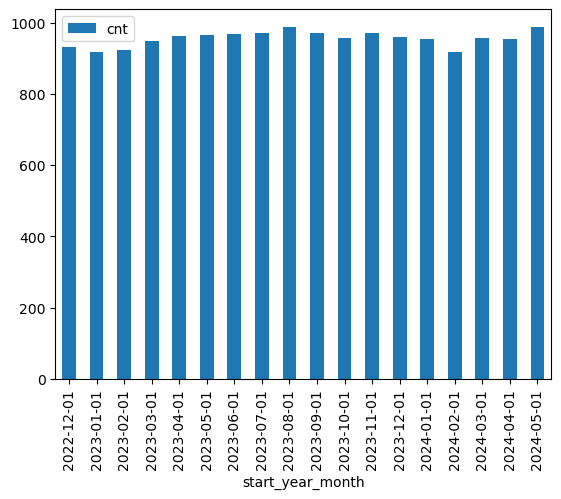

In [18]:
df3 = df3.limit(20).toPandas()
df3.plot(kind="bar", x="start_year_month", y="cnt")
plt.show()

In [19]:

df4 = df.groupBy("start_year_month").agg(F.countDistinct("driver_id").alias("cnt")).orderBy(F.col("cnt").desc())
df4.limit(10)


start_year_month,cnt
2023-08-01,988
2024-05-01,988
2023-09-01,972
2023-11-01,972
2023-07-01,970
2023-06-01,969
2023-05-01,965
2023-04-01,961
2023-12-01,959
2024-03-01,956


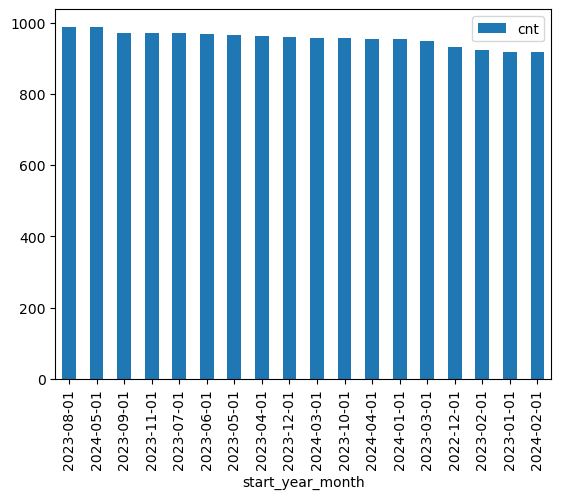

In [20]:
df4 = df4.limit(20).toPandas()
df4.plot(kind="bar", x="start_year_month", y="cnt")
plt.show()

## Count the Vehicles Per Month

Now let's count the vehicle_placard_numbers per month ordered by month, then ordered by count.

In [21]:

df5 = df.groupBy("start_year_month").agg(F.countDistinct("vehicle_placard_number").alias("cnt")).orderBy("start_year_month")
df5.limit(10)


start_year_month,cnt
2022-12-01,751
2023-01-01,746
2023-02-01,772
2023-03-01,768
2023-04-01,779
2023-05-01,807
2023-06-01,805
2023-07-01,804
2023-08-01,819
2023-09-01,822


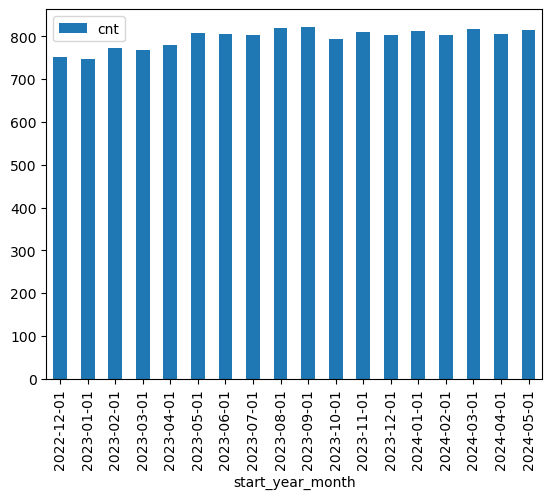

In [22]:
df5 = df5.limit(20).toPandas()
df5.plot(kind="bar", x="start_year_month", y="cnt")
plt.show()

In [23]:

df6 = df.groupBy("start_year_month").agg(F.countDistinct("vehicle_placard_number").alias("cnt")).orderBy(F.col("cnt").desc())
df6.limit(10)


start_year_month,cnt
2023-09-01,822
2023-08-01,819
2024-03-01,816
2024-05-01,815
2024-01-01,813
2023-11-01,811
2023-05-01,807
2024-04-01,806
2023-06-01,805
2023-12-01,804


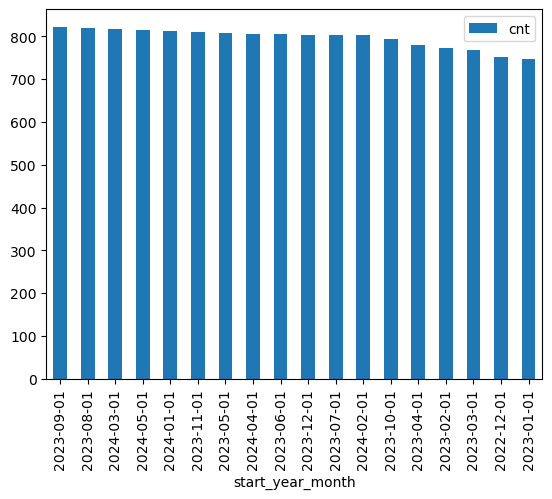

In [24]:
df6 = df6.limit(20).toPandas()
df6.plot(kind="bar", x="start_year_month", y="cnt")
plt.show()

## Count the Trips by Driver by Month

So far, the counts we have done have been of a single value. Next, let's count by multiple values. First, we will count by month and driver. First we'll sort by driver, then we will sort by count.

In [25]:

df.groupBy("start_year_month", "driver_id").count().orderBy(F.col("start_year_month"), F.col("driver_id")).limit(10)


start_year_month,driver_id,count
2022-12-01,-,1667
2022-12-01,1-9999,12
2022-12-01,6-9431,108
2022-12-01,9-6938,263
2022-12-01,A-0051,115
2022-12-01,A-0067,33
2022-12-01,A-0071,73
2022-12-01,A-0163,356
2022-12-01,A-0230,71
2022-12-01,A-0244,367


In [26]:
# df.groupBy("start_year_month", "driver_id").agg(F.count("driver_id").alias("cnt")).orderBy(F.col("cnt").desc()).limit(10)
df.groupBy("start_year_month", "driver_id").count().orderBy(F.col("count").desc()).limit(10)

start_year_month,driver_id,count
2023-01-01,-,28044
2023-02-01,-,14765
2024-02-01,-,6801
2024-02-01,D-4689,1885
2022-12-01,-,1667
2024-05-01,C-4064,1595
2024-05-01,B-5873,1593
2024-04-01,C-4064,1538
2024-03-01,C-4064,1536
2023-03-01,-,1467


## End of Apache Spark: Initial Analysis

This is the end of the first notebook. In notebook two, we'll repeat the analysis using SparkSQL.